In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import warnings

warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        # Suppress all warnings to keep the output clean
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail/Online Retail.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_excel('/kaggle/input/online-retail/Online Retail.xlsx')
df.head()

# --- Preprocessing ---

# 1. Identify Missing Values
missing_before = df.isnull().sum()

# 2. Handle Missing Values: Drop rows where CustomerID is missing (essential for customer analysis)
df_clean = df.dropna(subset=['CustomerID'])

# 3. Remove Noise: Filter out negative Quantity (Cancellations)
df_clean = df_clean[df_clean['Quantity'] > 0]

# 4. Feature Engineering: Create TotalCost
df_clean['TotalCost'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# --- Summary Output ---
print("### Data Summary After Cleaning")
print(f"Original Rows: {df.shape[0]}")
print(f"Cleaned Rows: {df_clean.shape[0]}")
print("\nMissing Values (Original):")
print(missing_before[missing_before > 0])
print("\nFirst 5 Rows of Cleaned Data:")
print(df_clean[['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID', 'TotalCost']].head().to_markdown(index=False, numalign="left", stralign="left"))

### Data Summary After Cleaning
Original Rows: 541909
Cleaned Rows: 397924

Missing Values (Original):
Description      1454
CustomerID     135080
dtype: int64

First 5 Rows of Cleaned Data:
| InvoiceNo   | Quantity   | UnitPrice   | CustomerID   | TotalCost   |
|:------------|:-----------|:------------|:-------------|:------------|
| 536365      | 6          | 2.55        | 17850        | 15.3        |
| 536365      | 6          | 3.39        | 17850        | 20.34       |
| 536365      | 8          | 2.75        | 17850        | 22          |
| 536365      | 6          | 3.39        | 17850        | 20.34       |
| 536365      | 6          | 3.39        | 17850        | 20.34       |


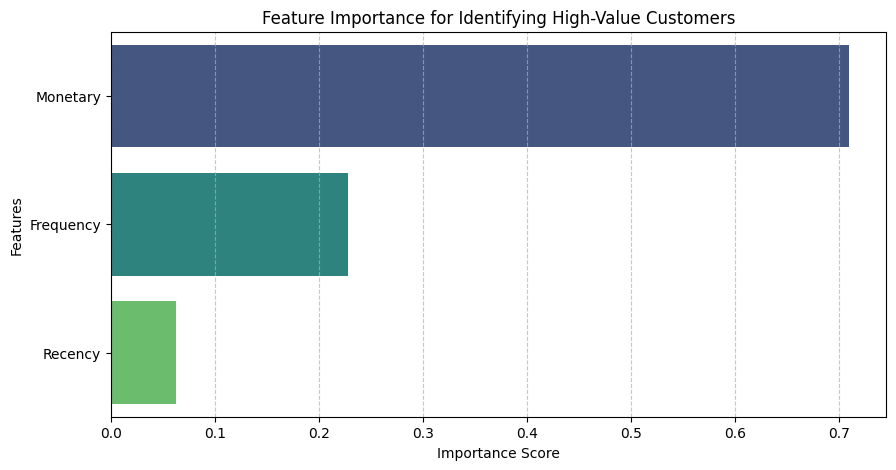

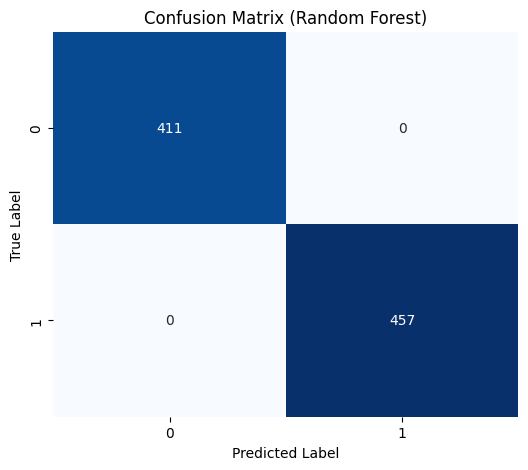


### Model Evaluation Metrics
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       457

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')

# --- RFM Calculation ---
# Reference date for Recency (1 day after the last purchase in the dataset)
current_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalCost': 'sum'                                      # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# --- Define Target Variable ---
# Label 'High Value' (1) if Monetary value is above the median, else (0)
median_monetary = rfm['Monetary'].median()
rfm['IsHighValue'] = np.where(rfm['Monetary'] > median_monetary, 1, 0)

# --- Modeling ---
X = rfm[['Recency', 'Frequency', 'Monetary']] # Features
y = rfm['IsHighValue'] # Target

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# --- Evaluation Visualization ---

# 1. Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importance for Identifying High-Value Customers')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 2. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n### Model Evaluation Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

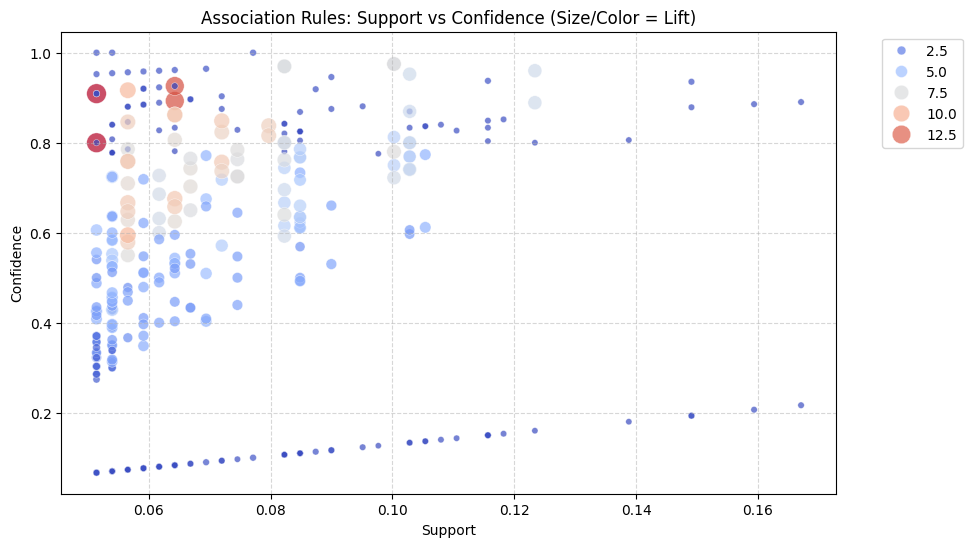


### Top 5 Association Rules (Sorted by Confidence)
| antecedents                                                                         | consequents                                  |   support |   confidence |    lift |
|:------------------------------------------------------------------------------------|:---------------------------------------------|----------:|-------------:|--------:|
| frozenset({'RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE '})      | frozenset({'POSTAGE'})                       | 0.0514139 |        1     | 1.29667 |
| frozenset({'PLASTERS IN TIN WOODLAND ANIMALS', 'RED TOADSTOOL LED NIGHT LIGHT'})    | frozenset({'POSTAGE'})                       | 0.0539846 |        1     | 1.29667 |
| frozenset({'JUMBO BAG WOODLAND ANIMALS'})                                           | frozenset({'POSTAGE'})                       | 0.0771208 |        1     | 1.29667 |
| frozenset({'SET/20 RED RETROSPOT PAPER NAPKINS ', 'SET/6 RED SPOTTY PAPER PLATES'}) | 

In [5]:
from mlxtend.frequent_patterns import apriori, association_rules
warnings.filterwarnings('ignore')

# --- Data Transformation (Basket Format) ---
basket_data = df_clean[df_clean['Country'] == 'France']

basket = (
    basket_data
    .groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Convert to boolean (REQUIRED by mlxtend)
basket_sets = basket > 0

# --- Frequent Itemsets & Rules ---
frequent_itemsets = apriori(
    basket_sets,
    min_support=0.05,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1
)

top_rules = rules.sort_values(
    by='confidence',
    ascending=False
).head(10)

# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rules,
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7
)
plt.title('Association Rules: Support vs Confidence (Size/Color = Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Top Rules ---
print("\n### Top 5 Association Rules (Sorted by Confidence)")
cols_to_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(top_rules[cols_to_show].head(5).to_markdown(index=False))




Classification Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       457

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



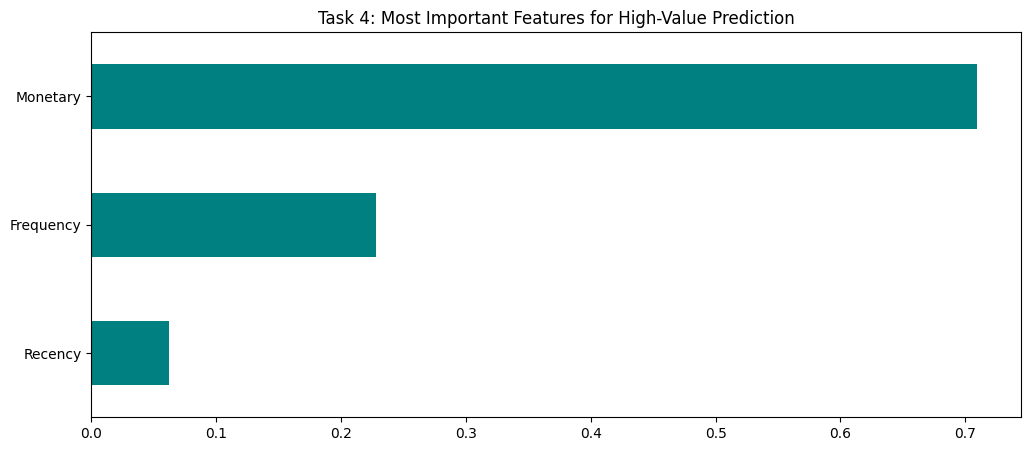


Top Product Bundles Identified:
                                 A                            B  Confidence  \
26      JUMBO BAG WOODLAND ANIMALS                      POSTAGE    1.000000   
138       RED RETROSPOT PICNIC BAG                      POSTAGE    0.964286   
153  SET OF 9 BLACK SKULL BALLOONS                      POSTAGE    0.961538   
55      PACK OF 6 SKULL PAPER CUPS                      POSTAGE    0.960000   
164  SET/6 RED SPOTTY PAPER PLATES  SET/6 RED SPOTTY PAPER CUPS    0.960000   

         Lift  
26   1.296667  
138  1.250357  
153  1.246795  
55   1.244800  
164  6.915556  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Warning Filter ---
warnings.filterwarnings('ignore')

# 1. DATA UNDERSTANDING & PREPROCESSING (Task 1)
def load_and_clean_data(file_path):
    # Loading the dataset
    df = pd.read_excel('/kaggle/input/online-retail/Online Retail.xlsx')
    df.head()
    # Handling Missing Values (Removing rows without CustomerID)
    df_clean = df.dropna(subset=['CustomerID'])
    
    # Removing Noise (Negative quantities/cancellations)
    df_clean = df_clean[df_clean['Quantity'] > 0]
    
    # Feature Engineering
    df_clean['TotalCost'] = df_clean['Quantity'] * df_clean['UnitPrice']
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    return df_clean

# 2. CLASSIFICATION: PREDICTING HIGH-VALUE CUSTOMERS (Task 2)
def perform_classification(df):
    # RFM Feature Extraction
    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
        'InvoiceNo': 'nunique',                                 # Frequency
        'TotalCost': 'sum'                                      # Monetary
    }).reset_index()
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    # Defining Target Variable (1 if spend > median, else 0)
    rfm['IsHighValue'] = (rfm['Monetary'] > rfm['Monetary'].median()).astype(int)

    # Modeling
    X = rfm[['Recency', 'Frequency', 'Monetary']]
    y = rfm['IsHighValue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Metrics
    y_pred = model.predict(X_test)
    print("Classification Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return model, X

# 3. ASSOCIATION RULES: MARKET BASKET ANALYSIS (Task 3)
def get_association_rules(df, country='France', min_support=0.05):
    # Basket Transformation
    basket = (df[df['Country'] == country]
              .groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum().unstack().fillna(0))
    basket_sets = (basket > 0).astype(int)
    
    # Frequent Itemsets (Manual support calculation)
    item_support = basket_sets.mean()
    frequent_items = item_support[item_support >= min_support].index
    
    # Association Rules Calculation
    rules = []
    pairs = basket_sets[frequent_items].T.dot(basket_sets[frequent_items]) / len(basket_sets)
    
    for a in frequent_items:
        for b in frequent_items:
            if a == b: continue
            support_ab = pairs.loc[a, b]
            if support_ab >= min_support:
                confidence = support_ab / item_support[a]
                lift = confidence / item_support[b]
                if lift > 1:
                    rules.append({'A': a, 'B': b, 'Support': support_ab, 'Confidence': confidence, 'Lift': lift})
    
    return pd.DataFrame(rules).sort_values('Confidence', ascending=False)

# --- EXECUTION ---
file_name = 'Online Retail.xlsx - Online Retail.csv'
data = load_and_clean_data(file_name)

# Run Task 2
clf_model, features = perform_classification(data)

# Run Task 3
assoc_rules = get_association_rules(data)

# 4. VISUALIZATION (Task 5 Output)
plt.figure(figsize=(12, 5))
# Plot Feature Importance
importances = pd.Series(clf_model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Task 4: Most Important Features for High-Value Prediction')
plt.show()

print("\nTop Product Bundles Identified:")
print(assoc_rules[['A', 'B', 'Confidence', 'Lift']].head(5))